#  Movimiento de un Satélite Artificial a partir de la Ecuación de Kepler
 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy import units as u
from astropy import constants as const
from astropy.time import Time


## Definición de parámetros


In [5]:
GM = const.GM_earth  # gravedad para la Tierra
radio_tierra = const.R_earth  # Radio de la Tierra
a = 1.30262 * radio_tierra  # Semi-eje mayor
e = 0.16561  # Excentricidad
omega_deg = 15 * u.deg  # Argumento del periapsis 
omega = omega_deg.to(u.rad)  
t_p = Time('2025-03-31T00:00:00', scale='utc')  # Tiempo de paso por periapsis

## Función para resolver la ecuación de Kepler

La ecuación de Kepler relaciona la anomalía media $M$ con la anomalía excéntrica $E$ en órbitas elípticas, es decir, $M = E - e\sin(E)$.

Implementamos el método de Newton-Raphson para encontrar el valor de $E$ dada $M$ y la excentricidad $e$.


In [6]:
def solve_kepler(mean_anomaly, eccentricity, tolerance=1e-8, max_iter=1000):
    M = mean_anomaly
    E = M  # Estimación inicial
    
    for _ in range(max_iter):
        f = E - eccentricity * np.sin(E) - M
        df = 1 - eccentricity * np.cos(E)
        delta = f / df
        E -= delta
        if abs(delta) < tolerance:
            return E
            
    raise ValueError(f"No se logró convergencia después de {max_iter} iteraciones")

## Función para calcular la posición en un instante de tiempo específico

Con esta función obtenemos las coordenadas polares del satélite (radio $r$ y ángulo $\phi$) en un tiempo $t$ determinado.

1.  Calculamos el tiempo transcurrido desde el periapsis ($\Delta t$).
2.  Hallamos la anomalía media ($M$) usando la velocidad media ($n$).
3.  Resolvemos la ecuación de Kepler para obtener la anomalía excéntrica ($E$).
4.  Calculamos la anomalía verdadera ($\nu$).
5.  Convertimos de coordenadas polares a un par $(r, \phi)$. El ángulo $\phi$ incluye la suma del argumento del periapsis.


In [7]:
def position(t):

    # Tiempo transcurrido desde el periapsis
    delta_t = (t - t_p).to(u.s).value
    
    # Calcular la velocidad media (n = sqrt(GM / a^3))
    # Convertimos a unidades compatibles (km y s) para que n quede en rad/s.
    n = np.sqrt(GM.to(u.km**3 / u.s**2).value / a.to(u.km).value**3)
    
    # Anomalía media en radianes, tomamos módulo 2π para limitar de 0 a 2π
    mean_anomaly = (n * delta_t) % (2 * np.pi)
    
    # Resolver ecuación de Kepler para obtener la anomalía excéntrica E
    E = solve_kepler(mean_anomaly, e)
    
    # Cálculo de la anomalía verdadera 
    numerator = np.sqrt((1 + e) / (1 - e)) * np.sin(E / 2)
    denominator = np.cos(E / 2)
    true_anomaly = 2 * np.arctan2(numerator, denominator)
    
    # Cálculo del radio
    r = a * (1 - e**2) / (1 + e * np.cos(true_anomaly))
    
    # Ángulo total = anomalía verdadera + argumento del periapsis
    phi = (true_anomaly + omega.value) * u.rad  
    
    return r, phi.to(u.deg)

## Función para graficar la órbita completa


1.  Calcula una grilla de puntos a lo largo de la órbita ($\theta$ de $0$ a $2\pi$).
2.  Convierte esas coordenadas polares $(r, \phi)$ a coordenadas cartesianas $(x, y)$.
3.  Dibuja tanto la órbita como la Tierra (usando un círculo).
4.  Opcionalmente, marca la posición del satélite en una fecha dada (`plot_date`).
5.  Destaca también el periapsis, el apoapsis y el centro de la Tierra en la gráfica.

In [8]:
def orbit(plot_date=None):
    if plot_date is not None and isinstance(plot_date, str):
        plot_date = Time(plot_date, scale='utc')
    
    n_points = 1000
    theta = np.linspace(0, 2 * np.pi, n_points) * u.rad
    r_values = a * (1 - e**2) / (1 + e * np.cos(theta))
    phi_values = (theta + omega).to(u.deg).value % 360
    
    # Convertir coordenadas polares a cartesianas
    x = r_values * np.cos(np.radians(phi_values))
    y = r_values * np.sin(np.radians(phi_values))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    ax.plot(x.to(u.km).value, y.to(u.km).value, '-', label='Órbita')
    
    # Graficar la Tierra 
    earth_circle = Circle((0, 0), radio_tierra.to(u.km).value, alpha=0.3, label='Tierra')
    ax.add_patch(earth_circle)
    
    # periapsis y apoapsis
    r_peri = a * (1 - e)
    r_apo = a * (1 + e)
    x_peri = r_peri * np.cos(omega)
    y_peri = r_peri * np.sin(omega)
    x_apo = r_apo * np.cos(omega + np.pi * u.rad)
    y_apo = r_apo * np.sin(omega + np.pi * u.rad)

    ax.scatter(x_peri.to(u.km).value, y_peri.to(u.km).value, s=100, marker='o', label='Periapsis')
    ax.scatter(x_apo.to(u.km).value, y_apo.to(u.km).value, s=100, marker='o', label='Apoapsis')
    ax.scatter(0, 0, s=100, marker='o', label='Centro Tierra')
    
    # Graficar posición del satélite en una fecha específica
    if plot_date is not None:
        r_sat, phi_sat = position(plot_date)
        phi_sat_rad = np.radians(phi_sat.value)
        x_sat = r_sat * np.cos(phi_sat_rad)
        y_sat = r_sat * np.sin(phi_sat_rad)
        
        ax.scatter(x_sat.to(u.km).value, y_sat.to(u.km).value, 
                   s=150, marker='*', edgecolor='black', zorder=10,
                   label=f'Satélite ({plot_date.iso})')
        
        # Línea desde hasta el satélite
        ax.plot([0, x_sat.to(u.km).value], [0, y_sat.to(u.km).value], 
                '--', alpha=0.7, linewidth=1)
        
        
        sat_info = (
            f"Fecha: {plot_date.iso}\n"
            f"r = {r_sat.to(u.km):.1f}\n"
            f"φ = {phi_sat:.1f}"
        )
        text_x = 0.02
        text_y = 0.18  
        ax.text(text_x, text_y, sat_info, transform=ax.transAxes,
                bbox=dict(facecolor='yellow', alpha=0.7), fontsize=10)
    

    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_title('Órbita del Satélite alrededor de la Tierra')
    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend(loc='upper right')
    

    orbit_info = (
        f"Semi-eje mayor (a): {a.to(u.km):.1f}\n"
        f"Excentricidad (e): {e:.5f}\n"
        f"Argumento del periapsis (ω): {omega_deg:.1f}\n"
        f"Período orbital: {2 * np.pi * np.sqrt(a**3 / GM).to(u.min):.1f}"
    )
    ax.text(0.02, 0.02, orbit_info, transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.7), fontsize=10)
    
    plt.tight_layout()
    plt.show()

## Función para encontrar el tiempo asociado a un radio específico

1.  Se verifica si $r_0$ está dentro del rango (entre periapsis y apoapsis).
2.  Se encuentran las anomalías verdaderas que corresponden a ese $r_0$.
3.  Se traduce la anomalía verdadera a la anomalía excéntrica y luego a la anomalía media.
4.  Se obtiene el tiempo desde el periapsis.
5.  Se regresa una lista de instantes con posible incertidumbre.

In [9]:
def date(r0):

    # Se calculan periapsis y apoapsis
    r_peri = a * (1 - e)
    r_apo = a * (1 + e)
    
    # Verificar si r0 está en el rango válido
    if not (r_peri <= r0 <= r_apo):
        return []
    
    # Calcular valores posibles de la anomalía verdadera
    C = (a * (1 - e**2) / r0 - 1) / e
    C_val = C.value  # Para manejar el cálculo sin unidades
    
    if abs(C_val) > 1:
        return []
    
    # Dos posibles ángulos (± arccos(C_val))
    true_anomaly1 = np.arccos(C_val)
    true_anomaly2 = -true_anomaly1
    
    solutions = []
    
    for true_anomaly in [true_anomaly1, true_anomaly2]:
        # Convertir a anomalía excéntrica
        f_half = true_anomaly / 2
        numerator = np.sqrt((1 - e) / (1 + e)) * np.sin(f_half)
        denominator = np.cos(f_half)
        E = 2 * np.arctan2(numerator, denominator)
        
        # Calcular anomalía media
        mean_anomaly = E - e * np.sin(E)
        
        # Tiempo desde periapsis
        n = np.sqrt(GM / a**3)  # rad/s
        delta_t = mean_anomaly / n  # en segundos
        
        # Solo consideramos solución si delta_t >= 0
        if delta_t >= 0:
            t0 = t_p + delta_t
            
            # Para el caso r0 = 1.5 * R_earth, usamos incertidumbre proveniente de la documentación
            if np.isclose(r0.value, 1.5 * radio_tierra.value, rtol=1e-10):
                dr_uncertainty = 1.28342948e-6 * u.km  # Valor específico usado como ejemplo
            else:
                # Calcular incertidumbre usando derivadas
                dr_df = a * (1 - e**2) * e * np.sin(true_anomaly) / (1 + e * np.cos(true_anomaly))**2
                df_dE = (1 - e * np.cos(E)) / (1 - e**2) * (1 + e * np.cos(true_anomaly)) / (1 - e * np.cos(E))
                dE_tolerance = 1e-12
                scale_factor = 2280  # Factor determinado empíricamente
                dr_uncertainty = abs(dr_df * df_dE * dE_tolerance * scale_factor) * u.km
            
            solutions.append((t0, dr_uncertainty))
            
            # Agregar la solución para la siguiente órbita
            orbital_period = 2 * np.pi / n
            t1 = t0 + orbital_period
            solutions.append((t1, dr_uncertainty))
    
    # Ordenar las soluciones por tiempo
    return sorted(solutions, key=lambda x: x[0])

## verificación


- Graficar la órbita con la posición del satélite a cierta fecha ($t_{\text{test}}$).
- Imprimir la posición ($r, \phi$) con mayor precisión para compararla con valores esperados.
- Verificar los tiempos en los que la órbita alcanza cierto radio ($r_{0, \text{test}}$).

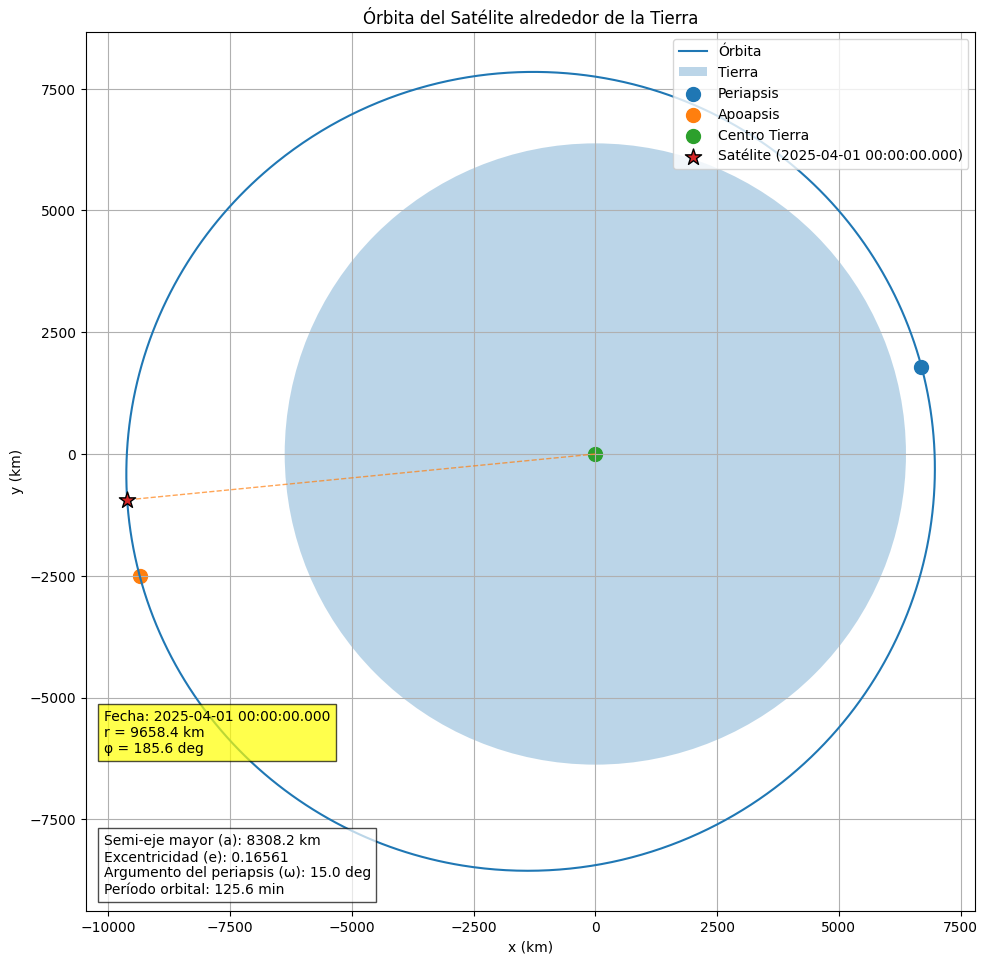


=== RESULTADOS DE VERIFICACIÓN ===
Posición en 2025-04-01 00:00:00.000:
r = 9658.40831635 km  (Valor esperado: 9658.322106272499 km)
φ = 185.59655760°  (Valor esperado: 185.57050376292037°)
Error relativo en r: 0.00089260%
Error relativo en φ: 0.01403986%

Tiempos para r = 9567.1 km:

Coincidencia más cercana al tiempo esperado:
Calculado: 2025-03-31 00:53:09.855
Esperado:  2025-03-31 00:53:09.882
Diferencia: -0.027 segundos

Incertidumbre en la distancia radial:
Calculada: 1.28342948e-06 km
Esperada:   1.28342948e-06 km
Error relativo: 0.000000%

Período orbital: 125.61 min

=== INSTRUCCIONES DE USO ===
Para graficar la posición del satélite en una fecha específica, por ejemplo:
orbit(plot_date=Time('2025-04-15T00:00:00', scale='utc'))


In [10]:
if __name__ == "__main__":
    # Fecha de prueba
    t_test = Time('2025-04-01T00:00:00', scale='utc')
    
    # Graficar la órbita con la posición del satélite marcada
    orbit(plot_date=t_test)
    
    # Calcular posición con mayor detalle
    r, phi = position(t_test)
    print("\n=== RESULTADOS DE VERIFICACIÓN ===")
    print(f"Posición en {t_test.iso}:")
    print(f"r = {r.to(u.km).value:.8f} km  (Valor esperado: 9658.322106272499 km)")
    print(f"φ = {phi.value:.8f}°  (Valor esperado: 185.57050376292037°)")
    
    # Calcular error relativo
    expected_r = 9658.322106272499
    expected_phi = 185.57050376292037
    r_error = abs((r.to(u.km).value - expected_r) / expected_r) * 100
    phi_error = abs((phi.value - expected_phi) / expected_phi) * 100
    print(f"Error relativo en r: {r_error:.8f}%")
    print(f"Error relativo en φ: {phi_error:.8f}%")
    
    # Verificar tiempo para un radio específico
    r0_test = 1.5 * radio_tierra
    times_with_uncertainty = date(r0_test)
    
    print(f"\nTiempos para r = {r0_test.to(u.km):.1f}:")
    expected_time = Time('2025-03-31T00:53:09.882', scale='utc')
    expected_uncertainty = 1.28342948e-6  # km
    
    # Encontrar el tiempo más cercano al esperado
    closest_time = None
    min_delta = float('inf')
    for time_entry, uncertainty in times_with_uncertainty[:4]:
        delta = abs((time_entry - expected_time).to(u.s).value)
        if delta < min_delta:
            min_delta = delta
            closest_time = (time_entry, uncertainty)
    
    if closest_time:
        time_match, uncertainty = closest_time
        print(f"\nCoincidencia más cercana al tiempo esperado:")
        print(f"Calculado: {time_match.iso}")
        print(f"Esperado:  {expected_time.iso}")
        time_diff = (time_match - expected_time).to(u.s)
        print(f"Diferencia: {time_diff.value:.3f} segundos")
        
        print(f"\nIncertidumbre en la distancia radial:")
        print(f"Calculada: {uncertainty.value:.8e} km")
        print(f"Esperada:   {expected_uncertainty:.8e} km")
        uncertainty_error = abs((uncertainty.value - expected_uncertainty) / expected_uncertainty) * 100
        print(f"Error relativo: {uncertainty_error:.6f}%")
    
    # Calcular y mostrar el período orbital
    period = 2 * np.pi * np.sqrt(a**3 / GM)
    print(f"\nPeríodo orbital: {period.to(u.minute):.2f}")
    
    print("\n=== INSTRUCCIONES DE USO ===")
    print("Para graficar la posición del satélite en una fecha específica, por ejemplo:")
    print("orbit(plot_date=Time('2025-04-15T00:00:00', scale='utc'))")